In [1]:
# Standard Library Imports
import warnings

# Third-Party Imports
import joblib
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
from pandas.api.types import is_numeric_dtype, is_string_dtype
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from scipy.stats import boxcox, ks_2samp, normaltest, shapiro, yeojohnson
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor, make_column_transformer
from sklearn.ensemble import (AdaBoostRegressor, ExtraTreesRegressor,
                              GradientBoostingRegressor,
                              HistGradientBoostingRegressor,
                              RandomForestRegressor, StackingRegressor,
                              VotingRegressor)
from sklearn.feature_selection import (RFECV, SelectKBest,
                                       mutual_info_regression, f_regression,VarianceThreshold)
from sklearn.impute import KNNImputer
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import (ElasticNet, Lasso, LinearRegression,
                                  Ridge, RidgeCV)
from sklearn.metrics import (make_scorer, mean_squared_error, 
                             mean_squared_log_error, 
                             mean_absolute_error)
from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV,KFold, RepeatedKFold,
                                     StratifiedKFold, StratifiedShuffleSplit,
                                     cross_val_score, cross_validate,
                                     train_test_split, learning_curve,permutation_test_score)
from sklearn.neighbors import KNeighborsRegressor, NearestNeighbors
from sklearn.pipeline import FeatureUnion, Pipeline, make_pipeline
from sklearn.preprocessing import (FunctionTransformer, MinMaxScaler,
                                   OneHotEncoder, PolynomialFeatures,
                                   PowerTransformer, RobustScaler,
                                   StandardScaler, QuantileTransformer)
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Local Imports
from statsmodels.graphics.gofplots import qqplot


pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
warnings.filterwarnings("ignore", category=UserWarning)

SEED = 42

In [2]:
# Load data
train = pd.read_csv('data/train.csv',index_col=0)
test = pd.read_csv('data/test.csv',index_col=0)
sub = pd.read_csv('data/sample_submission.csv',index_col=0)

# Understanding Abalone Dataset Features

- Sex: This feature represents the gender of the abalone,categorized as male (M), female (F), or infant (I).

- Length: The length feature denotes the longest measurement of the abalone shell, from the apex to the base, measured in millimeters.

- Diameter: Diameter represents the measurement of the abalone shell perpendicular to its length, also measured in millimeters.

- Height: This feature signifies the height of the abalone shell, measured perpendicular to the plane formed by the length and diameter, in millimeters.

- Whole weight: Whole weight indicates the total weight of the abalone, encompassing both the meat and the shell, measured in grams.

- Whole weight.1 (Shucked weight): This feature represents the weight of the abalone meat only, measured in grams. It indicates the amount of meat extracted from the shell.

- Whole weight.2 (Viscera weight): Viscera weight signifies the weight of the abalone gut after bleeding, measured in grams.It provides insights into the weight of the internal organs of the abalone.

- Shell weight: This feature represents the weight of the abalone shell only, excluding the meat, measured in grams. It provides insights into the weight distribution between the shell and the edible portion of the abalone.

- Rings: Rings signify the number of rings present on the abalone shell, serving as an indicator of the abalone's age.

In [3]:
def rename_and_lowercase(df):
    """Rename columns and convert them to lowercase"""
    df = df.copy()
    df = df.rename(columns = {'Whole weight.1':'shucked weight'})
    df = df.rename(columns = {'Whole weight.2':'viscera weight'})
    df = df.rename(columns=lambda x: x.lower().replace(' ', '_'))
    return df

train = rename_and_lowercase(train)
test = rename_and_lowercase(test)

train.columns, test.columns

(Index(['sex', 'length', 'diameter', 'height', 'whole_weight', 'shucked_weight',
        'viscera_weight', 'shell_weight', 'rings'],
       dtype='object'),
 Index(['sex', 'length', 'diameter', 'height', 'whole_weight', 'shucked_weight',
        'viscera_weight', 'shell_weight'],
       dtype='object'))

In [4]:
# function to calculate univariate stats like pandas describe method
def feature_creation(df):
    df = df.copy()
    df['length_diameter_ratio'] = df['length'] / df['diameter']
    df['height_diameter_ratio'] = df['height'] / df['diameter']
    df['volume'] = (4/3) * np.pi * (df['length']/2) * (df['diameter']/2) * (df['height']/2)
    df['shell_thickness_to_length'] = (df['whole_weight'] - df['shucked_weight']) / df['length']
    df['shell_thickness_to_diameter'] = (df['whole_weight'] - df['shucked_weight']) / df['diameter']
    return df


train = feature_creation(train)
test = feature_creation(test)

train.columns, test.columns

(Index(['sex', 'length', 'diameter', 'height', 'whole_weight', 'shucked_weight',
        'viscera_weight', 'shell_weight', 'rings', 'length_diameter_ratio',
        'height_diameter_ratio', 'volume', 'shell_thickness_to_length',
        'shell_thickness_to_diameter'],
       dtype='object'),
 Index(['sex', 'length', 'diameter', 'height', 'whole_weight', 'shucked_weight',
        'viscera_weight', 'shell_weight', 'length_diameter_ratio',
        'height_diameter_ratio', 'volume', 'shell_thickness_to_length',
        'shell_thickness_to_diameter'],
       dtype='object'))

# 1 - EDA - Exploratory Analysis

## 1.1 - Summary Statistics

In [5]:
def generate_summary_statistics(data):
  
    summary_table = pd.DataFrame(data.dtypes, columns=['dtypes'])
    summary_table['Missing'] = data.isnull().sum()
    summary_table['Unique'] = data.nunique()
    summary_table['Count'] = data.count()
    summary_table['Duplicated'] = data.duplicated().sum()
    summary_table['zero_values'] = data.isin([0]).sum()
    
    
    return summary_table

In [6]:
generate_summary_statistics(train)

,dtypes,Missing,Unique,Count,Duplicated,zero_values
sex,object,0,3,90615,0,0
length,float64,0,157,90615,0,0
diameter,float64,0,126,90615,0,0
height,float64,0,90,90615,0,6
whole_weight,float64,0,3175,90615,0,0
shucked_weight,float64,0,1799,90615,0,0
viscera_weight,float64,0,979,90615,0,0
shell_weight,float64,0,1129,90615,0,0
rings,int64,0,28,90615,0,0
length_diameter_ratio,float64,0,1742,90615,0,0


In [7]:
generate_summary_statistics(test)

,dtypes,Missing,Unique,Count,Duplicated,zero_values
sex,object,0,3,60411,0,0
length,float64,0,148,60411,0,0
diameter,float64,0,130,60411,0,0
height,float64,0,85,60411,0,2
whole_weight,float64,0,3037,60411,0,0
shucked_weight,float64,0,1747,60411,0,0
viscera_weight,float64,0,960,60411,0,0
shell_weight,float64,0,1089,60411,0,0
length_diameter_ratio,float64,0,1585,60411,0,0
height_diameter_ratio,float64,0,1232,60411,0,2


<div style="background-color: #343A1A; padding: 10px; border: 1px solid #ccc; border-radius: 5px;">
    <p>There are missing values in the dataset. The columns; <b>
    <ul>
    <li>height</li>
    <li>height_diameter_ratio</li>
    <li>volume</li>
    <li>shell_thickness_to_length</li>
    <li>shell_thickness_to_diameter</li>
<div>

## 1.2 - Univariate Analysis

In [8]:
# function to calculate univariate stats like pandas describe method
def univariate_stats(df):
    
    output_df = pd.DataFrame(columns=['Count', 'Missing', 'Unique', 'Dtype', 'IsNumeric', 'Mode', 'Mean', 'Min', '25%', 'Median', '75%', 'Max', 'Std', 'Skew', 'Kurt'])
    
    for col in df:
        if is_numeric_dtype(df[col]):
            output_df.loc[col] = [df[col].count(), df[col].isnull().sum(), df[col].nunique(), df[col].dtype, is_numeric_dtype(df[col]), df[col].mode().values[0], df[col].mean(), df[col].min(), df[col].quantile(.25), df[col].median(), df[col].quantile(.75), df[col].max(), df[col].std(), df[col].skew(), df[col].kurt() ]
        else:
            output_df.loc[col] = [df[col].count(), df[col].isnull().sum(), df[col].nunique(), df[col].dtype, is_numeric_dtype(df[col]), df[col].mode().values[0], '-', '-', '-', '-', '-', '-', '-', '-', '-' ]
    
    return output_df.sort_values(by=['IsNumeric', 'Unique'], ascending=False)

In [9]:
univariate_stats(train)

,Count,Missing,Unique,Dtype,IsNumeric,Mode,Mean,Min,25%,Median,75%,Max,Std,Skew,Kurt
shell_thickness_to_length,90615,0,45373,float64,True,1.0,0.79325,-1.423636,0.524211,0.813,1.028455,3.034109,0.355311,0.145555,-0.024374
shell_thickness_to_diameter,90615,0,40848,float64,True,1.1,1.017487,-1.9475,0.685294,1.042105,1.308743,3.727619,0.443251,0.126615,0.059561
volume,90615,0,13696,float64,True,0.020322,0.0172,0.0,0.008859,0.016933,0.023437,0.155756,0.010298,0.520469,0.521785
whole_weight,90615,0,3175,float64,True,0.5805,0.789035,0.002,0.419,0.7995,1.0675,2.8255,0.457671,0.429316,-0.185136
shucked_weight,90615,0,1799,float64,True,0.096,0.340778,0.001,0.1775,0.33,0.463,1.488,0.204428,0.591973,0.284012
length_diameter_ratio,90615,0,1742,float64,True,1.277778,1.295142,0.517241,1.262136,1.288889,1.321839,3.923077,0.059678,3.858978,97.000562
height_diameter_ratio,90615,0,1311,float64,True,0.333333,0.33603,0.0,0.313725,0.333333,0.355372,3.013333,0.038027,7.88554,460.137525
shell_weight,90615,0,1129,float64,True,0.24,0.225898,0.0015,0.12,0.225,0.305,1.005,0.130203,0.479092,0.096049
viscera_weight,90615,0,979,float64,True,0.1715,0.169422,0.0005,0.0865,0.166,0.2325,0.76,0.100909,0.476733,-0.203721
length,90615,0,157,float64,True,0.575,0.517098,0.075,0.445,0.545,0.6,0.815,0.118217,-0.732015,0.133364


**Note** : Volume, height_diameter_ratio, height,have some null values

In [10]:
univariate_stats(test)

,Count,Missing,Unique,Dtype,IsNumeric,Mode,Mean,Min,25%,Median,75%,Max,Std,Skew,Kurt
shell_thickness_to_length,60411,0,35538,float64,True,1.0,0.794252,-1.469811,0.525,0.815238,1.025214,2.784173,0.356306,0.150728,0.095958
shell_thickness_to_diameter,60411,0,32316,float64,True,0.4,1.01872,-1.997436,0.686154,1.043529,1.307692,3.365217,0.444567,0.127441,0.194221
volume,60411,0,11727,float64,True,0.019645,0.01723,0.0,0.008891,0.016881,0.023503,0.180216,0.010288,0.552281,1.124968
whole_weight,60411,0,3037,float64,True,0.5805,0.790062,0.002,0.4195,0.8015,1.07,2.8255,0.457591,0.435664,-0.165426
shucked_weight,60411,0,1747,float64,True,0.3485,0.341227,0.001,0.1785,0.329,0.4645,1.488,0.204221,0.593206,0.290172
length_diameter_ratio,60411,0,1585,float64,True,1.333333,1.294861,0.689655,1.262295,1.288889,1.321429,3.642857,0.059437,4.485283,110.399096
height_diameter_ratio,60411,0,1232,float64,True,0.333333,0.336547,0.0,0.313953,0.333333,0.355556,3.179104,0.040634,13.666839,827.656514
shell_weight,60411,0,1089,float64,True,0.24,0.226125,0.0015,0.12,0.225,0.305,1.004,0.129826,0.468524,0.042671
viscera_weight,60411,0,960,float64,True,0.1715,0.169419,0.0005,0.0865,0.166,0.2325,0.6415,0.10072,0.476129,-0.204883
length,60411,0,148,float64,True,0.575,0.517428,0.075,0.45,0.545,0.6,0.8,0.117609,-0.734565,0.141789


In [11]:
# list of numerical and categorical columns

numeric_cols = train.select_dtypes(exclude=['object']).columns.tolist()
categorical_cols = train.select_dtypes(include=['object']).columns.tolist()
target = 'rings'
numeric_cols_without_target = [col for col in numeric_cols if col != target]

numeric_cols, categorical_cols, numeric_cols_without_target

(['length',
  'diameter',
  'height',
  'whole_weight',
  'shucked_weight',
  'viscera_weight',
  'shell_weight',
  'rings',
  'length_diameter_ratio',
  'height_diameter_ratio',
  'volume',
  'shell_thickness_to_length',
  'shell_thickness_to_diameter'],
 ['sex'],
 ['length',
  'diameter',
  'height',
  'whole_weight',
  'shucked_weight',
  'viscera_weight',
  'shell_weight',
  'length_diameter_ratio',
  'height_diameter_ratio',
  'volume',
  'shell_thickness_to_length',
  'shell_thickness_to_diameter'])

In [12]:
# recursive elimination of features with cross validation
base_model = LGBMRegressor(force_col_wise=True,random_state=SEED)

min_features_to_select = 1

rfecv = RFECV(estimator=base_model, 
                step=1, 
                cv=KFold(n_splits=5, shuffle=True, random_state=SEED),
                scoring='neg_mean_squared_log_error',
                min_features_to_select=min_features_to_select,
                n_jobs=-1)

one_hot_encoded = pd.get_dummies(train[categorical_cols], prefix='sex')

train_encoded = pd.concat([train, one_hot_encoded], axis=1)

train_encoded = train_encoded.drop('sex', axis=1).drop('rings', axis=1)

print(train_encoded.columns)

rfecv.fit(train_encoded, train[target])

print(f"Optimal number of features: {rfecv.n_features_}")

Index(['length', 'diameter', 'height', 'whole_weight', 'shucked_weight',
       'viscera_weight', 'shell_weight', 'length_diameter_ratio',
       'height_diameter_ratio', 'volume', 'shell_thickness_to_length',
       'shell_thickness_to_diameter', 'sex_F', 'sex_I', 'sex_M'],
      dtype='object')
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 90615, number of used features: 15
[LightGBM] [Info] Start training from score 9.696794
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 90615, number of used features: 15
[LightGBM] [Info] Start training from score 9.696794
Optimal number of features: 15


In [13]:
#features selected by RFECV
selected_features = train_encoded.columns[rfecv.support_]

print(f"Selected features: {selected_features}")

# feature removed by RFECV
removed_features = train_encoded.columns[~rfecv.support_]
print(f"Removed features: {removed_features}")


Selected features: Index(['length', 'diameter', 'height', 'whole_weight', 'shucked_weight',
       'viscera_weight', 'shell_weight', 'length_diameter_ratio',
       'height_diameter_ratio', 'volume', 'shell_thickness_to_length',
       'shell_thickness_to_diameter', 'sex_F', 'sex_I', 'sex_M'],
      dtype='object')
Removed features: Index([], dtype='object')


### Histograms

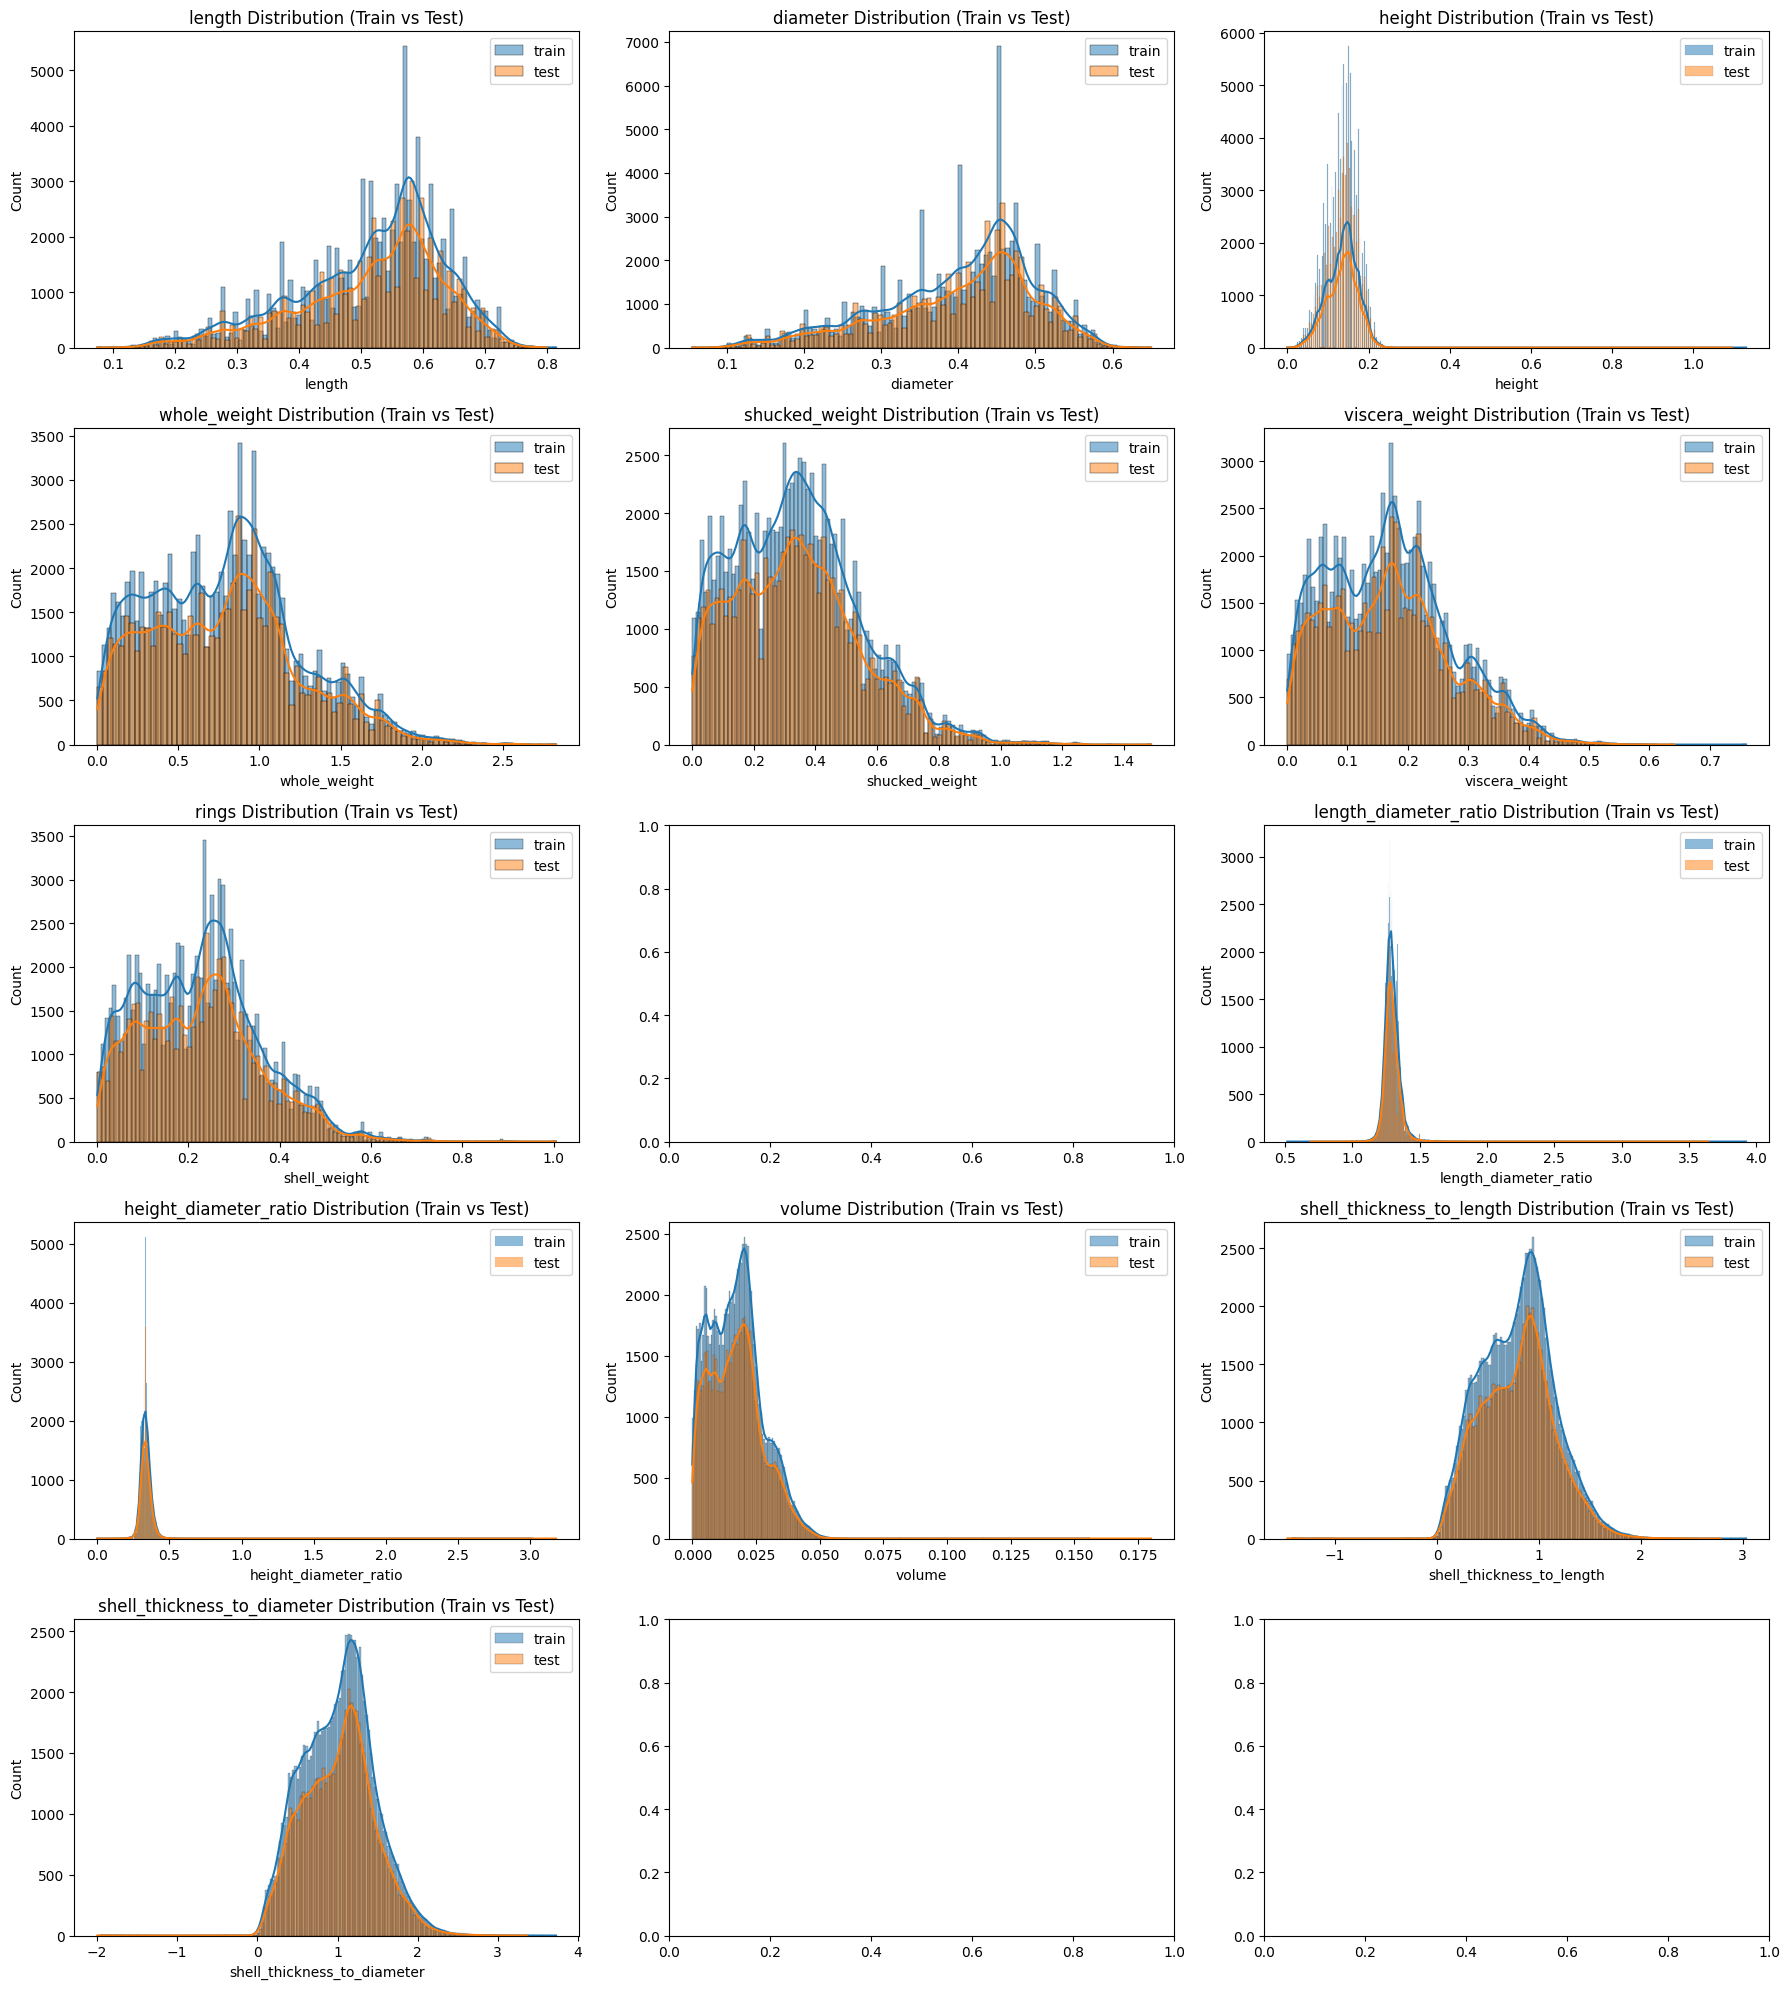

In [14]:
def plot_histograms(df_train, df_test, target_col, n_cols=3):
    n_rows = (len(df_train.columns) - 1) // n_cols + 1

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows))

    axes = axes.flatten()

    for i, var_name in enumerate(df_train.columns.tolist()):
        
        if var_name != target_col:
            ax = axes[i]
       
            # plot histogram for each variable in train
            sns.histplot(df_train[var_name], kde=True, ax=ax, label='train')

            # plot histogram for each variable in test
            sns.histplot(df_test[var_name], kde=True, ax=ax, label='test')

        
        ax.set_title(f'{var_name} Distribution (Train vs Test)')
        ax.legend()

    plt.tight_layout()
    plt.show()

plot_histograms(train[numeric_cols], test, target, n_cols=3)

### Distributions

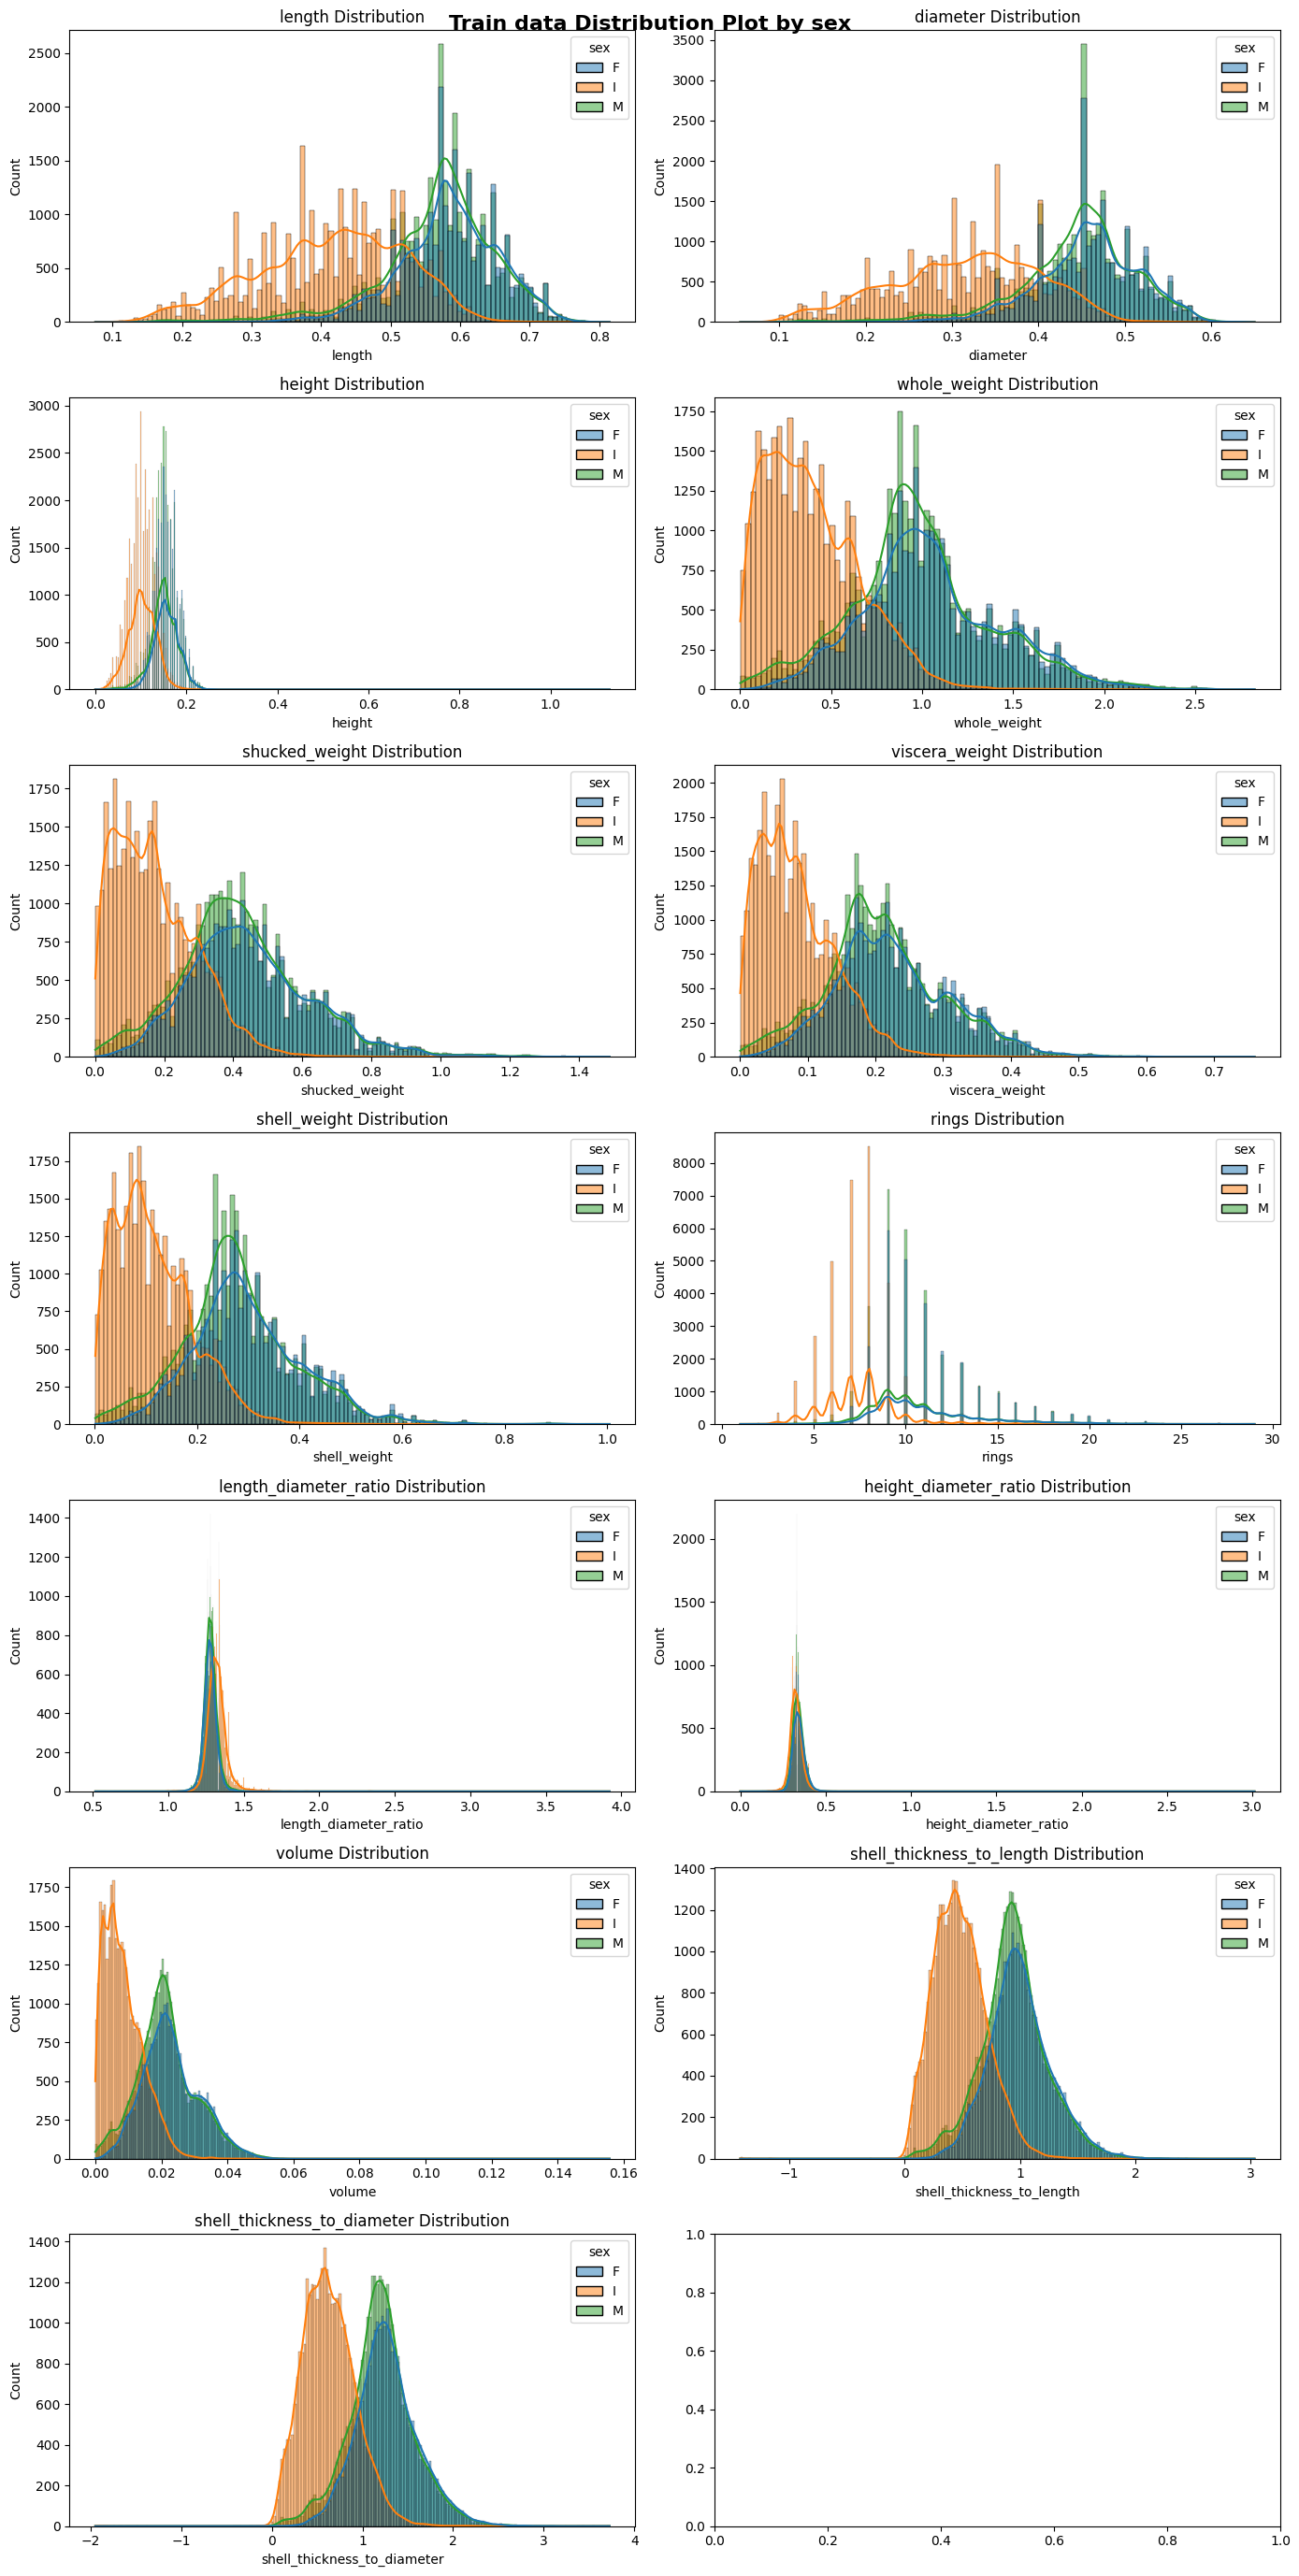

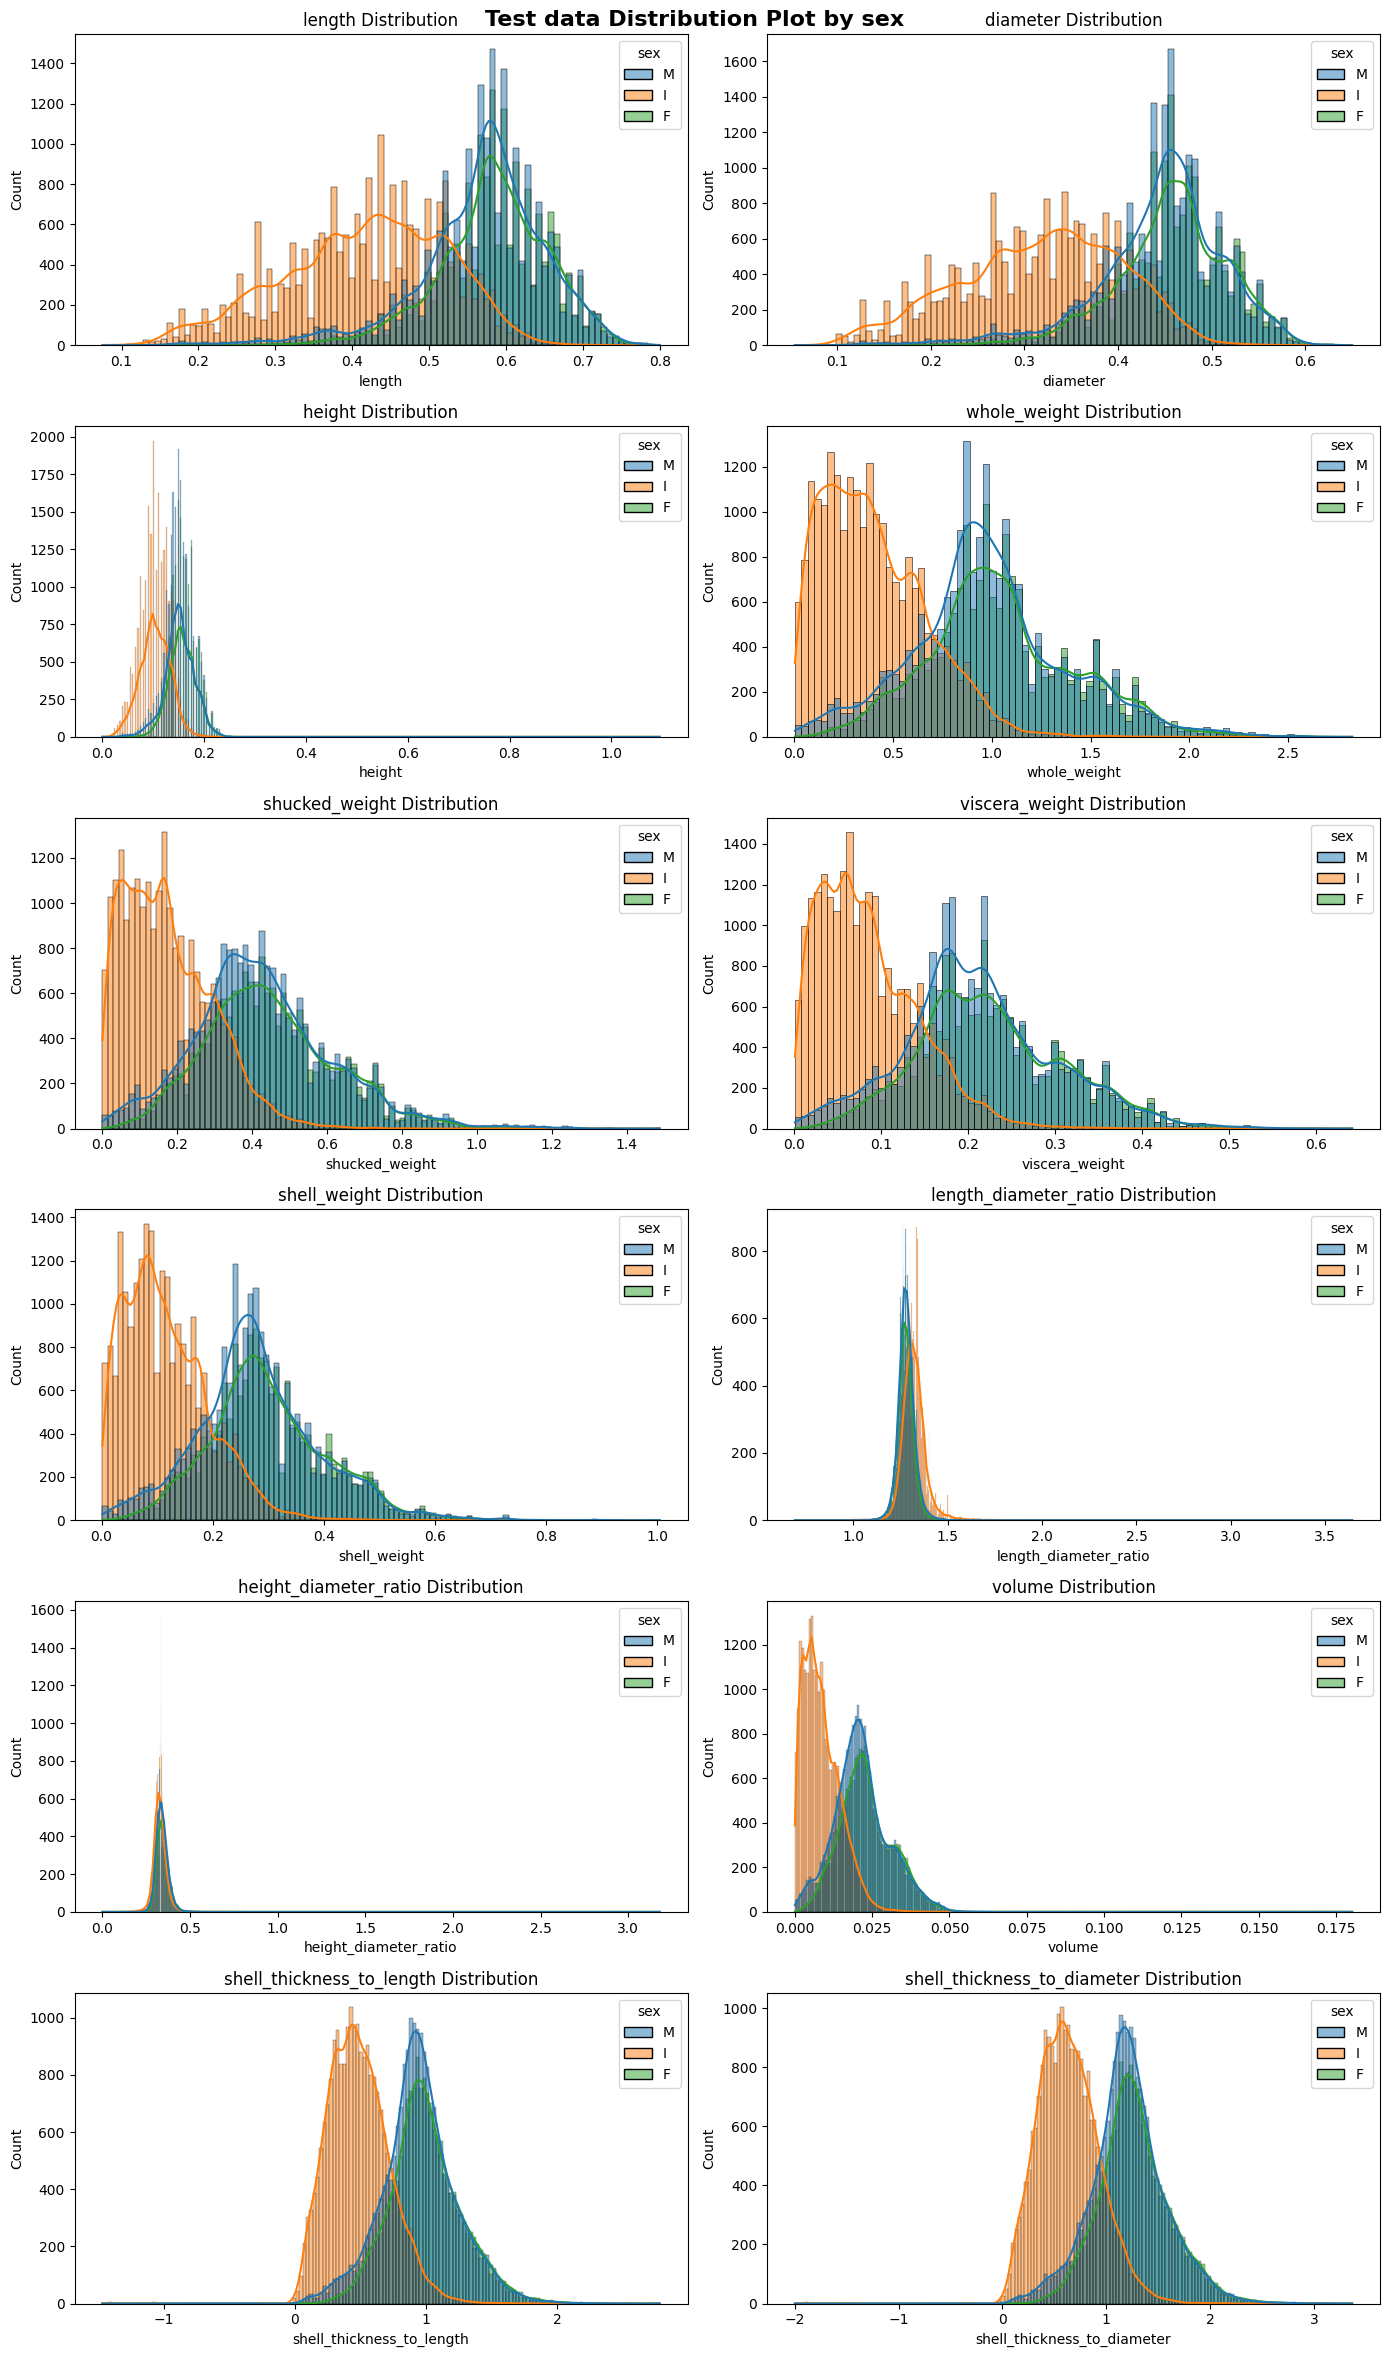

In [15]:
def plot_distributions(df, hue, title='', drop_cols=[]):
    
    cols = df.columns.drop([hue] + drop_cols)
    n_cols = 2
    n_rows = (len(cols) - 1) // n_cols + 1
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4 * n_rows))
    
    for i, var_name in enumerate(cols):
        row = i // n_cols
        col = i % n_cols
        
        ax = axes[row, col]
        sns.histplot(df, x=var_name, hue=hue, kde=True, ax=ax)
        ax.set_title(f'{var_name} Distribution')
    
    fig.suptitle(f'{title} Distribution Plot by {hue}', fontweight='bold', fontsize=16)
    plt.tight_layout()
    plt.show()
    
plot_distributions(train,hue='sex', title='Train data')
plot_distributions(test,hue='sex', title='Test data')

<div style="background-color: #343A1A; padding: 10px; border: 1px solid #ccc; border-radius: 5px;">
    
**Note:** 
<ul>
    <li>There is a big difference in distribution between I (infant) and adults (M or F). It almost like a binary variable, either is is infant or not</li>
    <li>Maybe test it feature engineering</li>
</ul>

</div>

In [16]:
# check if distributions of sex for "M" and "F" are statistically different
stat, p = ks_2samp(train['sex'].eq('M'),train['sex'].eq('F'))
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')

# cannot transform sex into a binary variable as the distribution

stat=0.050, p=0.000
Different distribution (reject H0)


### Correlations

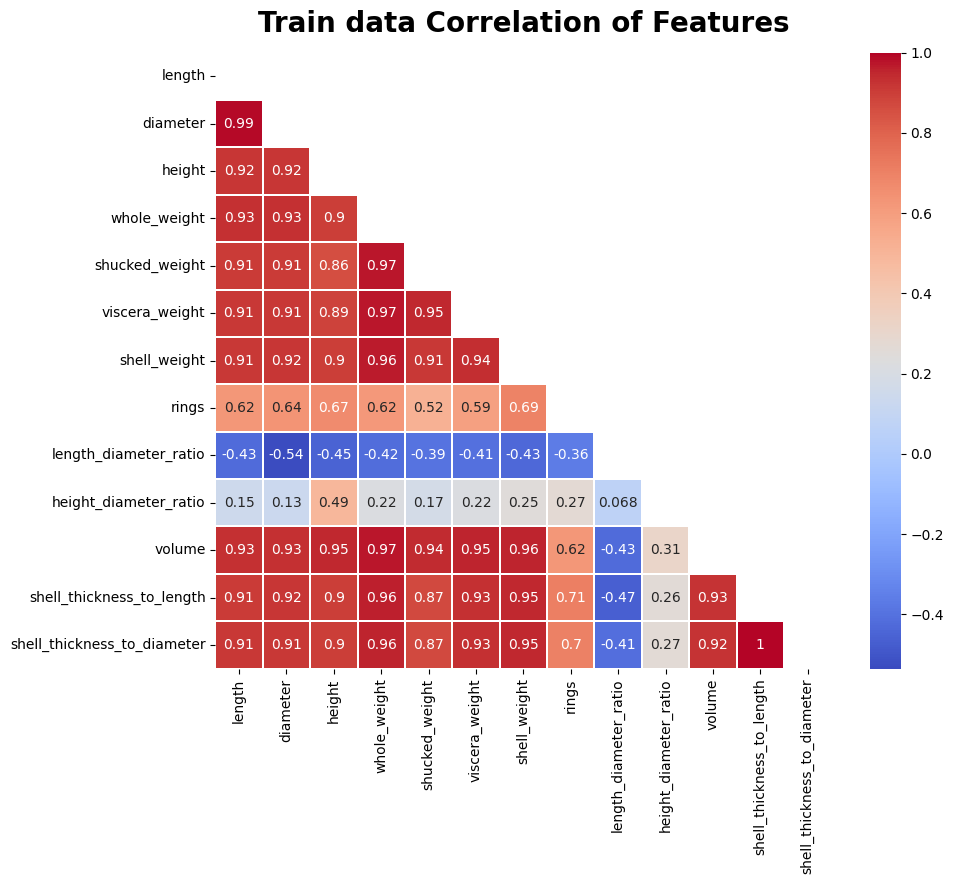

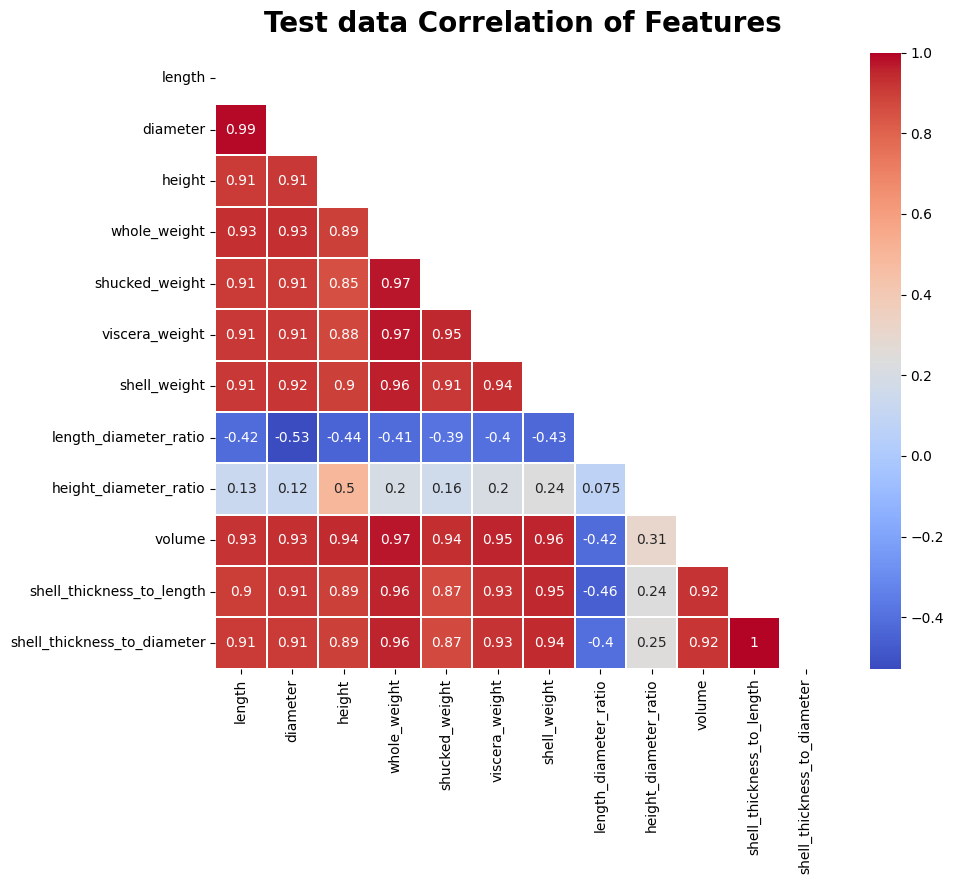

In [17]:
def plot_heatmap(df,title):
    
    mask = np.zeros_like(df.astype(float).corr())
    mask[np.triu_indices_from(mask)] = True
    
    plt.figure(figsize=(10, 8))
    
    plt.title(f'{title} Correlation of Features', fontweight='bold', y=1.02, size=20)
    
    sns.heatmap(df.astype(float).corr(),
                linewidths=0.1,
                vmax=1.0, 
                square=True, 
                cmap='coolwarm', 
                linecolor='white', 
                annot=True, 
                mask=mask)
    
plot_heatmap(train[numeric_cols], title='Train data')
plot_heatmap(test[numeric_cols_without_target], title='Test data')

<div style="background-color: #343A1A; padding: 10px; border: 1px solid #ccc; border-radius: 5px;">

**Notes**

<p>When all features are highly correlated, it can lead to multicollinearity in your model, which can make the model's estimates very sensitive to changes in the model. Here are a few strategies to handle this situation</p>

<ul>  
    <li><b>Feature Selection:</b> You can manually select a subset of your features based on domain knowledge or based on the correlation matrix</li>
    <li><b>Dimensionality Reduction:</b> Techniques like Principal Component Analysis (PCA) can be used to reduce the dimensionality of your data. PCA creates new uncorrelated variables that successively maximize variance</li>
    <li><b>Regularization:</b> Use a model that includes a penalty term for complexity in the loss function, such as Lasso or Ridge regression. These models can help to avoid overfitting by penalizing large coefficients</li>
    <li><b>Variance Inflation Factor (VIF):</b> Calculate the VIF for each variable, which measures how much the variance of the estimated regression coefficients are increased because of multicollinearity. If VIF is high for a variable, consider dropping it</li>
    <li><b>Combine Features:</b> If it makes sense in the context of your problem, you can combine correlated features into a single feature (for example, by taking an average)</li>
</ul>

</div>

In [18]:
# check which features are approximately normally distributed
def check_normality(df):
    for col in df.columns:
        if is_numeric_dtype(df[col]):
            print(f'{col} normality test results:')
            print(shapiro(df[col]))
            print(normaltest(df[col]))
            print("This distribution is approximately normal" if shapiro(df[col])[1] > 0.05 else "This distribution is not approximately normal")
            print('\n')
            
check_normality(train[numeric_cols])

length normality test results:
ShapiroResult(statistic=0.9585015177726746, pvalue=0.0)
NormaltestResult(statistic=6605.831769867752, pvalue=0.0)
This distribution is not approximately normal


diameter normality test results:
ShapiroResult(statistic=0.9590755701065063, pvalue=0.0)
NormaltestResult(statistic=6007.384380807614, pvalue=0.0)
This distribution is not approximately normal


height normality test results:
ShapiroResult(statistic=0.9756640791893005, pvalue=0.0)
NormaltestResult(statistic=19780.51596199518, pvalue=0.0)
This distribution is not approximately normal


whole_weight normality test results:
ShapiroResult(statistic=0.9759870767593384, pvalue=0.0)
NormaltestResult(statistic=2717.164607511156, pvalue=0.0)
This distribution is not approximately normal


shucked_weight normality test results:
ShapiroResult(statistic=0.9708635210990906, pvalue=0.0)
NormaltestResult(statistic=4796.649178696949, pvalue=0.0)
This distribution is not approximately normal


viscera_weight norm

<div style="background-color: #343A1A; padding: 10px; border: 1px solid #ccc; border-radius: 5px;">

**Notes**

<p>If the distribution of your data is not normal, there are several strategies you can use to transform your data to be more normally distributed:</p>
<div>
<ul>
<li><b>Log Transformation:</b> This is useful when your data is skewed. It can help to reduce the skewness.</li>
<pre>
<code>
df['log_transformed'] = np.log(df['original_column'])
</code>
</pre>
<li><b>Square Root Transformation:</b> This is another method to reduce skewness. It's less strong than the log transformation.</li>
<pre>
<code>
df['sqrt_transformed'] = np.sqrt(df['original_column'])
</code>
</pre>

<li><b>Yeo-Johnson Transformation:</b> This is similar to Box-Cox, but it can be used with zero and negative values.</li>
<pre>
<code>
df['yeojohnson_transformed'], _ = stats.yeojohnson(df['original_column'])
</code>
</pre>
<ul>
</div>
</div>

c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


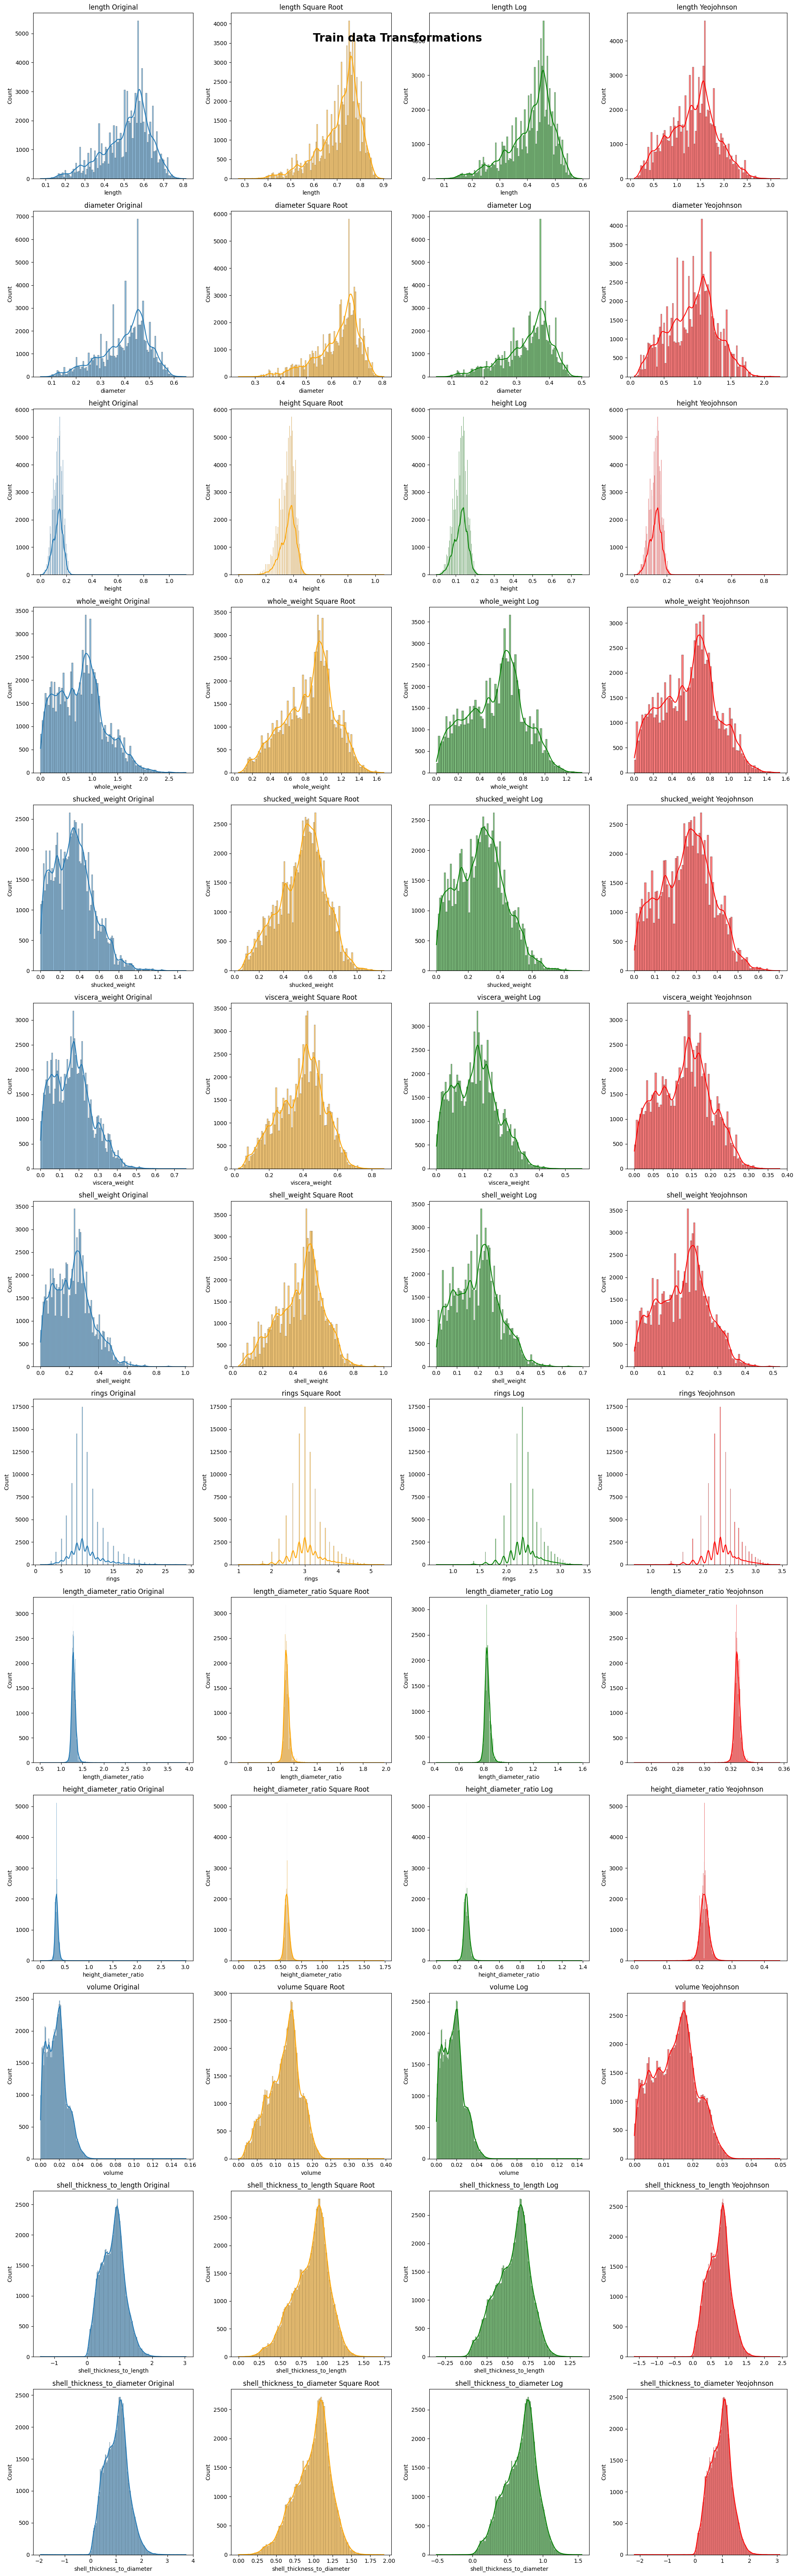

In [19]:
def plot_transformations(data, title, drop_cols=[]):
    
    data = data.drop(drop_cols, axis=1, errors='ignore')
    
    fig, axes = plt.subplots(len(data.columns), 4, figsize=(20, 5*len(data.columns)))
    
    for i, col in enumerate(data.columns):
        sns.histplot(data[col], kde=True, ax=axes[i, 0], label='Original')
        axes[i, 0].set_title(f'{col} Original')
        
        sns.histplot(np.sqrt(data[col]), kde=True, color='orange', ax=axes[i, 1], label='Square Root')
        axes[i, 1].set_title(f'{col} Square Root')
        
        sns.histplot(np.log1p(data[col]), kde=True, color='green', ax=axes[i, 2], label='Log')
        axes[i, 2].set_title(f'{col} Log')
        
        transformed, _ = yeojohnson(data[col])
        sns.histplot(transformed, kde=True, color='red', ax=axes[i, 3], label='Yeojohnson')
        axes[i, 3].set_title(f'{col} Yeojohnson')
    
    fig.suptitle(f'{title} Transformations', fontweight='bold', fontsize=20)
    plt.tight_layout()
    plt.show()
    
plot_transformations(train[numeric_cols], title='Train data');

In [20]:
train[numeric_cols_without_target]

,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,length_diameter_ratio,height_diameter_ratio,volume,shell_thickness_to_length,shell_thickness_to_diameter
id,,,,,,,,,,,,
0,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,1.279070,0.348837,0.018575,0.805455,1.030233
1,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,1.285714,0.295918,0.023437,1.066667,1.371429
2,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,1.454545,0.227273,0.000230,0.096875,0.140909
3,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,1.252632,0.315789,0.022197,0.905882,1.134737
4,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,1.305882,0.305882,0.016056,0.743243,0.970588
...,...,...,...,...,...,...,...,...,...,...,...,...
90610,0.335,0.235,0.075,0.1585,0.0685,0.0370,0.0450,1.425532,0.319149,0.003092,0.268657,0.382979
90611,0.555,0.425,0.150,0.8790,0.3865,0.1815,0.2400,1.305882,0.352941,0.018526,0.887387,1.158824
90612,0.435,0.330,0.095,0.3215,0.1510,0.0785,0.0815,1.318182,0.287879,0.007140,0.391954,0.516667


<div style="background-color: #343A1A; padding: 10px; border: 1px solid #ccc; border-radius: 5px;">

**Notes**

<p>Visual Inspection Conclusions</p>
<ul>
    <li><b>sqrt:</b> ['length', 'diameter', 'height', 'whole_weight', 'shucked_weight',
       'viscera_weight', 'shell_weight', 'rings', 'length_diameter_ratio',
       'height_diameter_ratio', 'volume', 'shell_thickness_to_length',
       'shell_thickness_to_diameter']</li>
    <li><b>yeo</b> ['length', 'diameter', 'height']</li>
<ul>

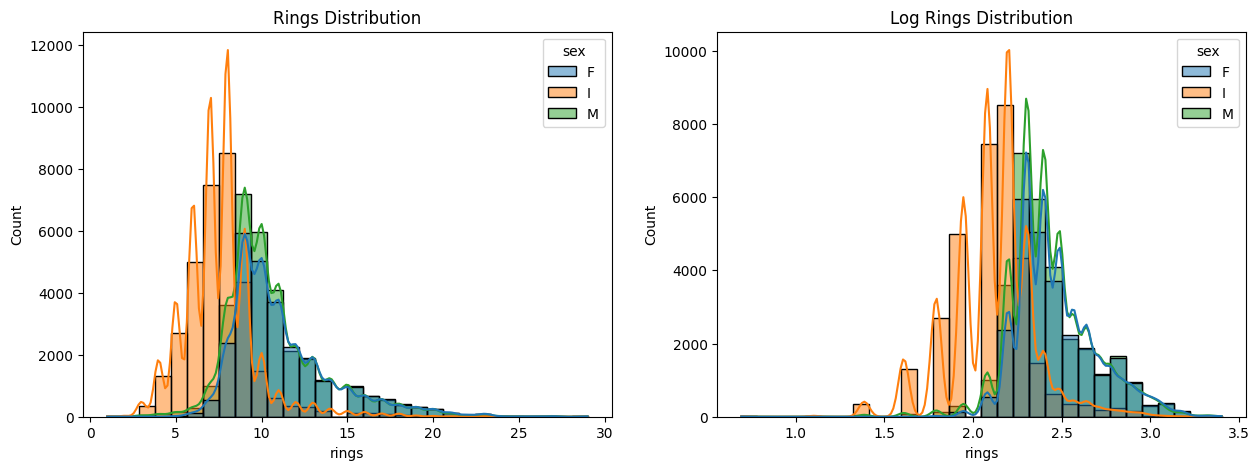

In [21]:
# Target variable distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(data=train, x='rings', kde=True, bins=30,hue='sex',ax=axes[0])
sns.histplot(data=train, x=np.log1p(train['rings']), kde=True, bins=30,hue='sex', ax=axes[1])
axes[0].set_title('Rings Distribution')
axes[1].set_title('Log Rings Distribution')
plt.show()

<div style="background-color: #343A1A; padding: 10px; border: 1px solid #ccc; border-radius: 5px;">

**Notes**
<ul>
    <li>
        <p>Initially target distribution is skewed, with sqrt transformation looks better</p>
    </li>
</ul>
</div>

### PairPlot

In [22]:
#sns.pairplot(data=train, vars=numeric_cols, hue='sex', diag_kind='kde', corner=True);

<div style="background-color: #343A1A; padding: 10px; border: 1px solid #ccc; border-radius: 5px;">

<p>Inferences</p>

<ol>
<li>There is a bit diference between an infant and adult Abalone</li>
<li>
<p>Linear relations:</p>
<ul>length vs diameter - (+++)  - </ul>
<ul>height vs length and diameter - (+) </ul>
<ul>between weights - (+++) with dispersion </ul>
<li>
<p>Polinomial relations</p>
<ul>all weights vs length - poly2, exp</ul>
<ul>all weights vs diameter - pol2, exp </ul>
</li>
<li>Sex is an important feature to destinguist between infant and adult</li>
<ol>

<div>

# 3 - Pipelines

In [23]:
train[numeric_cols_without_target].columns

Index(['length', 'diameter', 'height', 'whole_weight', 'shucked_weight',
       'viscera_weight', 'shell_weight', 'length_diameter_ratio',
       'height_diameter_ratio', 'volume', 'shell_thickness_to_length',
       'shell_thickness_to_diameter'],
      dtype='object')

In [24]:

sqrt_columns = ['whole_weight', 'shucked_weight','viscera_weight', 'shell_weight', 'length_diameter_ratio','height_diameter_ratio', 'volume', 'shell_thickness_to_length','shell_thickness_to_diameter']
yeojohnson_columns = ['length', 'diameter', 'height']
cat_colums = ['sex']

X = train.drop(columns='rings')
y = train['rings']


yeojohnson_transformer = Pipeline(steps=[
    ('yeo_johnson', PowerTransformer(method='yeo-johnson')),
    ('scaler', StandardScaler())
    ])


sqrt_transformer = Pipeline(steps=[
    ('sqrt', FunctionTransformer(np.sqrt)),
    ('scaler', StandardScaler())
    ])

    

preprocessor = ColumnTransformer(
    transformers=[
        ('power_transformer', yeojohnson_transformer, yeojohnson_columns),
        ('sqrt_transformer', sqrt_transformer, sqrt_columns),
        ('encoder_sex', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# Define target transformer
target_transformer = TransformedTargetRegressor(regressor=LGBMRegressor(force_col_wise=True, random_state=SEED),
                                                func=np.sqrt, 
                                                inverse_func=np.square)

# Define the pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', target_transformer)  # Add your model after feature selection
])

pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('power_transformer',
                                                  Pipeline(steps=[('yeo_johnson',
                                                                   PowerTransformer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['length', 'diameter',
                                                   'height']),
                                                 ('sqrt_transformer',
                                                  Pipeline(steps=[('sqrt',
                                                                   FunctionTransformer(func=<ufunc 'sqrt'>)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['whole_weight',
                                                   'shucked_weight',
                                                   'vis...ht',
                                                   'shell_weight',
                                                   'length_diameter_ratio',
                                                   'height_diameter_ratio',
                                                   'volume',
                                                   'shell_thickness_to_length',
                                                   'shell_thickness_to_diameter']),
                                                 ('encoder_sex',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['sex'])])),
                ('model',
                 TransformedTargetRegressor(func=<ufunc 'sqrt'>,
                                            inverse_func=<ufunc 'square'>,
                                            regressor=LGBMRegressor(force_col_wise=True,
                                                                    random_state=42)))])

In [25]:
def objective(trial):
    
   # Define the hyperparameters to optimize
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'max_depth': trial.suggest_int('max_depth', 1, 8),
        'learning_rate' : trial.suggest_float('learning_rate',0.01,1, log=True),
        'n_estimators' : trial.suggest_int('n_estimators',10,10000),
        'objective': 'regression',
        'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0, 0.1),
        'min_child_weight': trial.suggest_float('min_child_weight', 0, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 20),
        'subsample': trial.suggest_float('subsample', 0.5, 1),
        'subsample_freq': trial.suggest_int('subsample_freq', 1, 10),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 0.1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 0.1),
        'importance_type': 'gain'   
    }
   
    # Initialize LightGBM model with suggested hyperparameters 
    target_transformer = TransformedTargetRegressor(regressor=LGBMRegressor(**params,
                                                                            force_col_wise=True, 
                                                                            random_state=SEED),
                                                    func=np.sqrt, 
                                                    inverse_func=np.square)



    # Create a pipeline with preprocessing and XGBoost model
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', target_transformer)
    ])

    cv = KFold(n_splits=5, shuffle=True, random_state=SEED)

    # Calculate the cross-validated negative RMSLE score
    scores = -1 * cross_val_score(pipeline,
                                    X,
                                    y,
                                    cv=cv,
                                    scoring='neg_root_mean_squared_log_error',
                                    n_jobs=-1)

    return scores.mean()

In [32]:
# %%time

# # # perform hyperparameter optimization with Optuna
# study = optuna.create_study(direction='minimize', study_name='lightGBM_feature_scaling_with_extra_features')
# study.optimize(objective, n_trials=100)

# print('\n----------------------------------------\n')
# print(f'Best trial: {study.best_trial.params}')
# print(f'Best score: {study.best_value}')

In [33]:
# best_params = study.best_trial.params

# best_params

In [27]:
best_paramns_lgbm = {'num_leaves': 100, 'max_depth': 5, 'learning_rate': 0.010235170920993884, 'n_estimators': 6358, 'min_gain_to_split': 0.04615119053194238, 'min_child_weight': 5.483807955910911, 'min_child_samples': 13, 'subsample': 0.8706570349112508, 'subsample_freq': 5, 'colsample_bytree': 0.6288956349541829, 'reg_alpha': 0.09205029675133272, 'reg_lambda': 0.05199378377421014}

In [28]:
# Initialize XGBoost model with best hyperparameters
model_LightGBM_tunned = LGBMRegressor(**best_paramns_lgbm,force_col_wise=True, random_state=SEED)

#fit the model
pipe_lgbm_tunned = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model_LightGBM_tunned)
])

pipe_lgbm_tunned.fit(X, y)

c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\internals\blocks.py:366: RuntimeWarning: invalid value encountered in sqrt
  result = func(self.values, **kwargs)


[LightGBM] [Warning] min_gain_to_split is set=0.04615119053194238, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.04615119053194238
[LightGBM] [Warning] min_gain_to_split is set=0.04615119053194238, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.04615119053194238
[LightGBM] [Info] Total Bins 2613
[LightGBM] [Info] Number of data points in the train set: 90615, number of used features: 15
[LightGBM] [Info] Start training from score 9.696794
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('power_transformer',
                                                  Pipeline(steps=[('yeo_johnson',
                                                                   PowerTransformer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['length', 'diameter',
                                                   'height']),
                                                 ('sqrt_transformer',
                                                  Pipeline(steps=[('sqrt',
                                                                   FunctionTransformer(func=<ufunc 'sqrt'>)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['whole_weight',
                                                   'shucked_weight',
                                                   'vis...
                 LGBMRegressor(colsample_bytree=0.6288956349541829,
                               force_col_wise=True,
                               learning_rate=0.010235170920993884, max_depth=5,
                               min_child_samples=13,
                               min_child_weight=5.483807955910911,
                               min_gain_to_split=0.04615119053194238,
                               n_estimators=6358, num_leaves=100,
                               random_state=42, reg_alpha=0.09205029675133272,
                               reg_lambda=0.05199378377421014,
                               subsample=0.8706570349112508,
                               subsample_freq=5))])

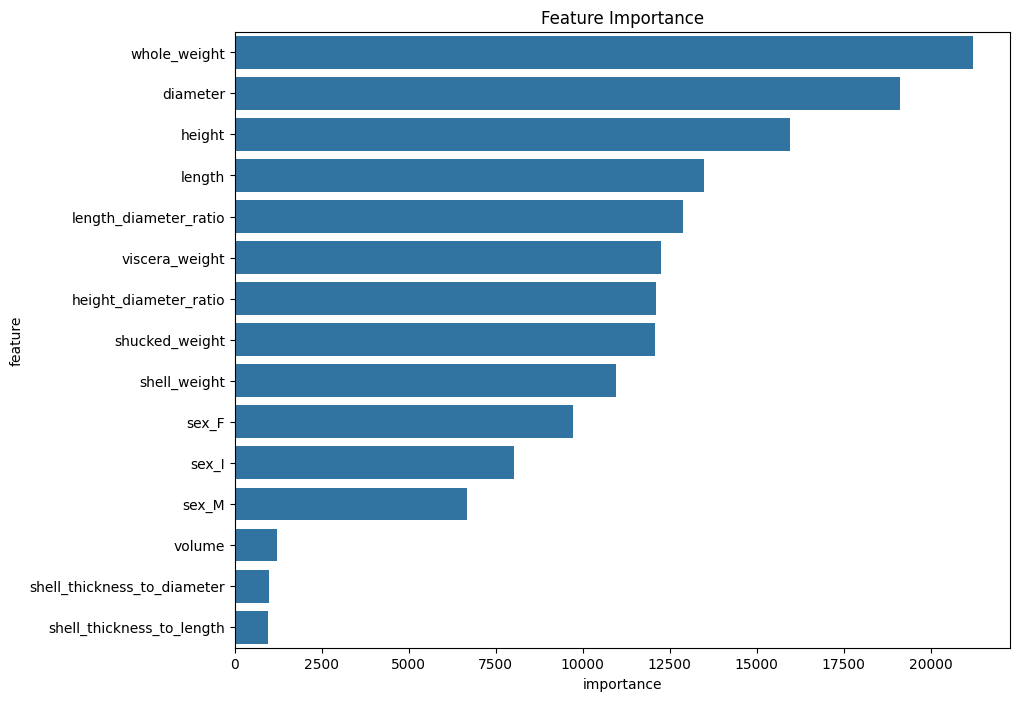

In [57]:
# feature importance
feature_importance = pipe_lgbm_tunned.named_steps['model'].feature_importances_

# get feature names
cat_features_names = pipe_lgbm_tunned.named_steps['preprocessor'].transformers_[2][1].get_feature_names_out()
power_features_names = pipe_lgbm_tunned.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out()
sqrt_features_names = pipe_lgbm_tunned.named_steps['preprocessor'].transformers_[1][1].feature_names_in_

assert len(cat_features_names) + len(power_features_names) + len(sqrt_features_names) == len(feature_importance)

# dataframe with feature importance
feature_importance_df = pd.DataFrame({'feature': np.concatenate([cat_features_names, power_features_names, sqrt_features_names]),
                                      'importance': feature_importance})

# sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# plot feature importance
plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance_df, x='importance', y='feature')
plt.title('Feature Importance')
plt.show()


In [58]:
# transform the test data 
joblib.dump(pipe_lgbm_tunned, 'models/lgbm_tunned_extra_features_v3.pkl')

['models/lgbm_tunned_extra_features_v3.pkl']

# Predictions

In [59]:
#load the model
model = joblib.load('models/lgbm_tunned_extra_features_v3.pkl')

# predict on test data
y_pred = model.predict(test)

y_pred[:10]                       

c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\internals\blocks.py:366: RuntimeWarning: invalid value encountered in sqrt
  result = func(self.values, **kwargs)


[LightGBM] [Warning] min_gain_to_split is set=0.04615119053194238, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.04615119053194238


array([ 9.94688377,  9.80515329,  9.99067221, 10.27826677,  7.76012001,
        9.27581325, 11.19588175,  6.20826243,  7.95009752, 10.81155433])

In [60]:
# Create a DataFrame for the submission data
submission_data = pd.DataFrame(y_pred, index=test.index, columns=['rings'])

submission_data

,rings
id,
90615,9.946884
90616,9.805153
90617,9.990672
90618,10.278267
90619,7.760120
...,...
151021,6.494113
151022,9.241668
151023,13.846501


In [61]:
# Save the DataFrame to a CSV file

submission_data
submission_data.to_csv('outputs/submission_lgbm_best_transformations_extra_features_v3.csv')

kagge public result was: `0.14807`

# stuff to do

- optimize for catboost
- voting
- emsemble
- add more features
- conversion to log(y)